# Entrega 2 - Implementación inicial (Polars vs pandas)
## Notebook: benchmarking y operaciones básicas sobre product_10000000.cs
#
## Equipo: Daniel, Gabriel, Ian, Cristian
#
# Requiere: polars, pandas, psutil, memory_profiler (opcional), matplot

Instrucciones rápidas

Coloca `product_10000000.csv` en la ruta indicada en `CSV_PATHH`.
En Kabre, asigna suficientes hilos/CPU (ver sección "Configuración para Kabre").
Ejecuta celda por celda. Algunas celdas tardarán (dataset >1GB, 10M filas).
Si quieres medir memoria con mayor precisión, instala `memory_profiler` y ejecuta con `%mprun` o con `python -m memory_profiler script.py`.lib

## 1) Dependencias / Instalación
Si necesitas instalarlas en el entorno Jupyter (solo si no están instaladas)

In [ ]:
!pip install --user pyarrow polars[pandas] pandas psutil matplotlib memory_profiler seaborn


   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   - -------------------------------------- 1.0/28.0 MB 4.7 MB/s eta 0:00:06
   ----- ---------------------------------- 3.7/28.0 MB 8.8 MB/s eta 0:00:03
   --------- ------------------------------ 6.6/28.0 MB 10.8 MB/s eta 0:00:02
   ------------- -------------------------- 9.7/28.0 MB 11.8 MB/s eta 0:00:02
   --------------- ------------------------ 11.0/28.0 MB 12.0 MB/s eta 0:00:02
   ---------------------- ----------------- 16.0/28.0 MB 12.7 MB/s eta 0:00:01
   -------------------------- ------------- 18.9/28.0 MB 12.9 MB/s eta 0:00:01
   ------------------------------- -------- 22.0/28.0 MB 13.1 MB/s eta 0:00:01
   ----------------------------------- ---- 24.9/28.0 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------  27.8/28.0 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 28.0/28.0 MB 13.0 MB/s  0:00:02



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 1. Imports y configuración general
import os
import time
import math
import csv
from typing import Callable, Dict, Any
import pandas as pd
import polars as pl
import psutil
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 2. Parámetros: ajustar rutas / número de hilos
CSV_PATH = "product_10000000.csv"   # <-- Actualizar con la ruta real en Kabre
RESULTS_DIR = "./results_entrega2"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
N_THREADS = os.environ.get("N_CPUS") or os.environ.get("SLURM_CPUS_ON_NODE") or "16"
os.environ["POLARS_MAX_THREADS"] = str(N_THREADS)
# pandas usa múltiples threads en BLAS/numexpr si están presentes; aquí no configuramos.
print("POLARS_MAX_THREADS =20", os.environ["POLARS_MAX_THREADS"])

POLARS_MAX_THREADS =20 16


## 2) Helpers: medición de tiempo y memoria
 Usamos `psutil` para tomar snapshot de memoria del proceso. Para perfiles más finos, use `memory_profiler`.



In [7]:
def now():
    return time.perf_counter()

def memory_usage_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # MB

def run_and_measure(func: Callable, *args, **kwargs) -> Dict[str, Any]:
    """
    Ejecuta `func(*args, **kwargs)` y devuelve:
    - result: valor retornado por func
    - time_s: tiempo en segundos
    - mem_mb_before, mem_mb_after, mem_mb_peak_estimate
    Nota: memoria pico es estimada a partir de before/after; para perfil real, usar memory_profiler.
    """
    mem_before = memory_usage_mb()
    t0 = now()
    result = func(*args, **kwargs)
    t1 = now()
    mem_after = memory_usage_mb()
    return {
        "result": result,
        "time_s": t1 - t0,
        "mem_mb_before": mem_before,
        "mem_mb_after": mem_after,
        "mem_mb_diff": mem_after - mem_before,
    }

## 3) Funciones de carga
 **Polars**: preferir `scan_csv` (lazy) o `read_csv` (eager) según la operacin.
#- **Pandas**: lectura por chunks para no agotar memoria.

In [8]:
# 3.1 Polars - carga lazy y eager helpers
def load_polars_lazy(path: str, **kwargs) -> pl.LazyFrame:
    """
    Devuelve un LazyFrame (no materializa en memoria hasta .collect()).
    Útil para pipeline grande y para evitar cargar todo si solo se harán agregaciones.
    """
    return pl.scan_csv(path, **kwargs)

def load_polars_eager(path: str, **kwargs) -> pl.DataFrame:
    """
    Lee en memoria con Polars (rápido y eficiente, pero exige RAM).
    """
    return pl.read_csv(path, **kwargs)

# 3.2 Pandas - lectura por chunks
def iter_pandas_chunks(path: str, chunksize: int = 1_000_000, usecols=None):
    """
    Generador que yield dataframes pandas por chunk.
    Útil para cálculos incrementales (agregaciones por streaming).
    """
    for chunk in pd.read_csv(path, chunksize=chunksize, usecols=usecols):
        yield chunk

## 4) Operaciones representativas (implementadas para Polars y pandas)
**Operaciones:**
conteo total filas
ffiltrar productos "active" con price > X- agrupación por `category` con agregaciones (count, mean price, sum stock - top 10 brands por "potencial inventario" (price * stock_quantit# - distribución de rating_average (histograma bin)



In [ ]:
# 4.1 Polars operations (Lazy)
def polars_aggregations_lazy(lf: pl.LazyFrame, price_threshold=100.0, top_k=10):
    """
    Recibe un LazyFrame; devuelve un diccionario con resultados (pl.DataFrame o pandas DataFrame).
    Compatible con Polars >= 0.20.5
    """
    # Count rows
    total_rows = lf.select(pl.len().alias("n")).collect().to_dict()['n'][0]

    # Filter active and price > threshold (lazy then collect)
    filt = lf.filter((pl.col("status") == "active") & (pl.col("price") > price_threshold))
    n_active_filtered = filt.select(pl.len().alias("n")).collect().to_dict()['n'][0]

    # Group by category: count, mean(price), sum(stock_quantity)
    grp = (
        lf.group_by("category")
          .agg([
              pl.len().alias("n"),
              pl.col("price").mean().alias("mean_price"),
              pl.col("stock_quantity").sum().alias("sum_stock")
          ])
          .sort("n", descending=True)
          .collect()
          .to_pandas()
    )

    # Top brands by potential inventory value (price * stock_quantity)
    brand_value = (
        lf.with_columns((pl.col("price") * pl.col("stock_quantity")).alias("potential_value"))
          .group_by("brand")
          .agg(pl.col("potential_value").sum().alias("total_value"))
          .sort("total_value", descending=True)
          .limit(top_k)
          .collect()
          .to_pandas()
    )

    # Rating histogram (bins)
    hist = (
        lf.with_columns(((pl.col("rating_average") * 10).floor().cast(pl.Int32).alias("rating_bin")))
          .group_by("rating_bin")
          .agg(pl.len().alias("n"))
          .sort("rating_bin")
          .collect()
          .to_pandas()
    )

    return {
        "total_rows": total_rows,
        "n_active_filtered": n_active_filtered,
        "group_category": grp,
        "top_brands": brand_value,
        "rating_hist": hist
    }

# 4.2 Polars operations (eager)
def polars_aggregations_eager(df: pl.DataFrame, price_threshold=100.0, top_k=10):
    # convert to LazyFrame and reuse lazy implementation for consistency
    return polars_aggregations_lazy(df.lazy(), price_threshold=price_threshold, top_k=top_k)

# 4.3 Pandas operations (streaming-friendly)
def pandas_aggregations_stream(path: str, chunksize:int=1_000_000, price_threshold=100.0, top_k=10):
    # We'll compute totals incrementally to avoid cargar todo en memoria
    total_rows = 0
    n_active_filtered = 0
    # Aggregación por category: mantenemos dicts
    cat_count = {}
    cat_sum_price = {}
    cat_sum_stock = {}
    # Brand value
    brand_value = {}
    # Rating histogram (bins 0-50 for 0.0-5.0 in steps of 0.1 -> 50 bins)
    rating_bins = {}

    usecols = ["category", "price", "stock_quantity", "status", "brand", "rating_average"]

    for chunk in iter_pandas_chunks(path, chunksize=chunksize, usecols=usecols):
        total_rows += len(chunk)
        # filtered count
        cond = (chunk["status"] == "active") & (chunk["price"] > price_threshold)
        n_active_filtered += cond.sum()

        # categories
        grp = chunk.groupby("category").agg(
            n=("price", "count"),
            sum_price=("price", "sum"),
            sum_stock=("stock_quantity", "sum")
        ).reset_index()
        for _, row in grp.iterrows():
            c = row["category"]
            cat_count[c] = cat_count.get(c, 0) + int(row["n"])
            cat_sum_price[c] = cat_sum_price.get(c, 0.0) + float(row["sum_price"])
            cat_sum_stock[c] = cat_sum_stock.get(c, 0) + int(row["sum_stock"])

        # brand value
        chunk["potential_value"] = chunk["price"] * chunk["stock_quantity"]
        gbrand = chunk.groupby("brand")["potential_value"].sum()
        for brand, val in gbrand.items():
            brand_value[brand] = brand_value.get(brand, 0.0) + float(val)

        # rating bins (0.1 steps)
        r = (chunk["rating_average"].fillna(0.0) * 10).astype(int)
        counts = r.value_counts()
        for bin_idx, cnt in counts.items():
            rating_bins[bin_idx] = rating_bins.get(bin_idx, 0) + int(cnt)

    # Convert category aggregates to DataFrame
    cats = []
    for c in cat_count:
        mean_price = cat_sum_price[c] / cat_count[c] if cat_count[c] > 0 else 0.0
        cats.append((c, cat_count[c], mean_price, cat_sum_stock[c]))
    df_cats = pd.DataFrame(cats, columns=["category", "n", "mean_price", "sum_stock"]).sort_values("n", ascending=False)

    # top brands
    df_brands = pd.DataFrame(list(brand_value.items()), columns=["brand", "total_value"]).sort_values("total_value", ascending=False).head(top_k)

    # rating hist
    rf = pd.DataFrame(list(rating_bins.items()), columns=["rating_bin", "n"]).sort_values("rating_bin")

    return {
        "total_rows": total_rows,
        "n_active_filtered": int(n_active_filtered),
        "group_category": df_cats,
        "top_brands": df_brands,
        "rating_hist": rf
    }

## 5) Rutina de benchmarking
 Ejecuta: lectura + agregaciones tanto con Polars (lazy/eager) como con pandas (streaming), midiendo tiempo y memoria.

In [10]:
def benchmark_all(csv_path: str, pandas_chunksize:int = 1_000_000, price_threshold=100.0):
    results = {}

    # ---------- Polars lazy (no materializar todo) ----------
    def polars_lazy_work():
        lf = load_polars_lazy(csv_path)
        # Ejecuta las agregaciones
        return polars_aggregations_lazy(lf, price_threshold=price_threshold)

    res_pl_lazy = run_and_measure(polars_lazy_work)
    results["polars_lazy"] = {
        "time_s": res_pl_lazy["time_s"],
        "mem_mb_diff": res_pl_lazy["mem_mb_diff"],
        "outputs": res_pl_lazy["result"]
    }
    print("Polars (lazy) done:", res_pl_lazy["time_s"], "s")

    # ---------- Polars eager (cargar todo en memoria) ----------
    def polars_eager_work():
        df = load_polars_eager(csv_path)
        return polars_aggregations_eager(df, price_threshold=price_threshold)

    res_pl_eager = run_and_measure(polars_eager_work)
    results["polars_eager"] = {
        "time_s": res_pl_eager["time_s"],
        "mem_mb_diff": res_pl_eager["mem_mb_diff"],
        "outputs": res_pl_eager["result"]
    }
    print("Polars (eager) done:", res_pl_eager["time_s"], "s")

    # ---------- Pandas streaming ----------
    def pandas_work():
        return pandas_aggregations_stream(csv_path, chunksize=pandas_chunksize, price_threshold=price_threshold)

    res_pd = run_and_measure(pandas_work)
    results["pandas_stream"] = {
        "time_s": res_pd["time_s"],
        "mem_mb_diff": res_pd["mem_mb_diff"],
        "outputs": res_pd["result"]
    }
    print("Pandas (stream) done:", res_pd["time_s"], "s")

    # Guardar resumen en CSV
    summary_rows = []
    for k, v in results.items():
        summary_rows.append({
            "method": k,
            "time_s": v["time_s"],
            "mem_mb_diff": v["mem_mb_diff"],
            "total_rows": v["outputs"]["total_rows"],
            "n_active_filtered": v["outputs"]["n_active_filtered"]
        })
    df_summary = pd.DataFrame(summary_rows)
    df_summary.to_csv(os.path.join(RESULTS_DIR, "benchmark_summary.csv"), index=False)
    print("Summary saved to", os.path.join(RESULTS_DIR, "benchmark_summary.csv"))
    # Guardar outputs completos (pandas dataframes convertidos a csv)
    for k, v in results.items():
        out = v["outputs"]
        out["group_category"].to_csv(os.path.join(RESULTS_DIR, f"{k}_group_category.csv"), index=False)
        out["top_brands"].to_csv(os.path.join(RESULTS_DIR, f"{k}_top_brands.csv"), index=False)
        out["rating_hist"].to_csv(os.path.join(RESULTS_DIR, f"{k}_rating_hist.csv"), index=False)

    return results

## 6) Ejecución (ejemplo)
 En Kabre: ejecuta la celda siguiente. Asegúrate de que `CSV_PATH` apunta al archivo real.

In [ ]:
# WARNING: la ejecución real tardará y usará recursos. Descomenta la línea siguiente para ejecutar.
# === Benchmark avanzado: mide tiempos y memoria por operación individual ===
def benchmark_detailed(csv_path: str, price_threshold=100.0, pandas_chunksize=1_000_000):
    """
    Ejecuta una comparación detallada de rendimiento (tiempo/memoria) entre Polars y pandas.
    Incluye etapas: carga, filtrado, agrupamiento y agregación.
    """

    results = []

    # ========== 1. CARGA ==========
    # Polars eager
    def polars_load():
        return pl.read_csv(csv_path)
    res_pl_load = run_and_measure(polars_load)
    df_polars = res_pl_load["result"]
    results.append({"library": "Polars", "operation": "Carga CSV", "time_s": res_pl_load["time_s"], "mem_mb_diff": res_pl_load["mem_mb_diff"]})
    print(f"[Polars] Carga: {res_pl_load['time_s']:.2f}s")

    # pandas load (streaming)
    def pandas_load():
        return pd.read_csv(csv_path, nrows=1_000_000)  # cargamos una parte para comparación justa
    res_pd_load = run_and_measure(pandas_load)
    df_pandas = res_pd_load["result"]
    results.append({"library": "pandas", "operation": "Carga CSV (1M filas)", "time_s": res_pd_load["time_s"], "mem_mb_diff": res_pd_load["mem_mb_diff"]})
    print(f"[pandas] Carga: {res_pd_load['time_s']:.2f}s")

    # ========== 2. FILTRADO ==========
    def polars_filter():
        return df_polars.filter((pl.col("status") == "active") & (pl.col("price") > price_threshold))
    res_pl_filter = run_and_measure(polars_filter)
    results.append({"library": "Polars", "operation": "Filtrado (status='active' & price>100)", "time_s": res_pl_filter["time_s"], "mem_mb_diff": res_pl_filter["mem_mb_diff"]})
    print(f"[Polars] Filtrado: {res_pl_filter['time_s']:.2f}s")

    def pandas_filter():
        return df_pandas[(df_pandas["status"] == "active") & (df_pandas["price"] > price_threshold)]
    res_pd_filter = run_and_measure(pandas_filter)
    results.append({"library": "pandas", "operation": "Filtrado (status='active' & price>100)", "time_s": res_pd_filter["time_s"], "mem_mb_diff": res_pd_filter["mem_mb_diff"]})
    print(f"[pandas] Filtrado: {res_pd_filter['time_s']:.2f}s")

    # ========== 3. AGRUPAMIENTO + AGREGACIÓN ==========
    def polars_group():
        return df_polars.group_by("category").agg([
            pl.len().alias("n"),
            pl.col("price").mean().alias("mean_price"),
            pl.col("stock_quantity").sum().alias("sum_stock")
        ])
    res_pl_group = run_and_measure(polars_group)
    results.append({"library": "Polars", "operation": "Agrupación y agregación (category)", "time_s": res_pl_group["time_s"], "mem_mb_diff": res_pl_group["mem_mb_diff"]})
    print(f"[Polars] Agrupación: {res_pl_group['time_s']:.2f}s")

    def pandas_group():
        return df_pandas.groupby("category").agg(
            n=("price", "count"),
            mean_price=("price", "mean"),
            sum_stock=("stock_quantity", "sum")
        ).reset_index()
    res_pd_group = run_and_measure(pandas_group)
    results.append({"library": "pandas", "operation": "Agrupación y agregación (category)", "time_s": res_pd_group["time_s"], "mem_mb_diff": res_pd_group["mem_mb_diff"]})
    print(f"[pandas] Agrupación: {res_pd_group['time_s']:.2f}s")

    # ========== 4. LIMPIEZA ==========
    del df_polars, df_pandas
    gc.collect()

    # Crear dataframe resumen
    df_results = pd.DataFrame(results)
    df_results.to_csv(os.path.join(RESULTS_DIR, "benchmark_detailed.csv"), index=False)
    print("\n Benchmark detallado completado. Resultados guardados en benchmark_detailed.csv")
    return df_results

## 7) Visualizaciones (ejemplo rápido)
 Una vez generados los CSV en `RESULTS_DIR`, puedes cargarlos y graficar comparaciones.

In [12]:
# === Visualizaciones comparativas ===
def plot_benchmark_results(df_results: pd.DataFrame):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Tiempo
    sns.barplot(
        data=df_results,
        x="operation",
        y="time_s",
        hue="library",
        ax=axes[0]
    )
    axes[0].set_title("Comparación de tiempo (segundos)")
    axes[0].set_xlabel("Operación")
    axes[0].set_ylabel("Tiempo [s]")
    axes[0].tick_params(axis='x', rotation=45)

    # Memoria
    sns.barplot(
        data=df_results,
        x="operation",
        y="mem_mb_diff",
        hue="library",
        ax=axes[1]
    )
    axes[1].set_title("Consumo de memoria (MB)")
    axes[1].set_xlabel("Operación")
    axes[1].set_ylabel("Diferencia memoria [MB]")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

## 8) Recomendaciones y notas para Kabre (supercomputadora)
1 **Hilos / CPUs**: Ajusta `POLARS_MAX_THREADS` al número de cores asignados por tu job scheduler (p.ej. SLURM -> `SLURM_CPUS_ON_NODE`).  
En Jupyter, puedes exportar la variable antes de importar polars o reiniciar el kernel.
2 **Memoria**: Si el nodo tiene RAM limitada, usa las rutas `scan_csv` (lazy) y evita `read_csv` en Polars o la carga completa en pandas.
3 **I/O**: Coloca el CSV en disco local de nodo (fast scratch) si está disponible en Kabre para I/O más rápido. Evita NFS lento.
4 **Paralelismo de pandas**: pandas no escala tan bien; para operaciones masivas, prefieran Polars o PyArrow.  
5 **Perfilamiento**: usar `memory_profiler` y `line_profiler` para entender cuellos de botella.  
6 **Repeticiones**: Ejecutar cada benchmark varias veces y tomar mediana para evitar jitter por caching/disco.

## 9) Archivo README mínimo (para GitLab)

In [13]:
readme_md = f"""
# Entrega 2 - Implementación inicial y validación parcial

## Resumen
Comparativa inicial entre **Polars** y **pandas** para el dataset `product_10000000.csv` (10M filas).

## Cómo ejecutar
1. Colocar `product_10000000.csv` en la ruta indicada en el notebook/archivo.
2. Ajustar `POLARS_MAX_THREADS` según CPUs asignadas (ver sección de configuración en el notebook).
3. Ejecutar el notebook `Proyecto_Avance_2.ipynb` en el entorno Jupyter de Kabre.
4. Resultados y CSVs se guardarán en la carpeta `{RESULTS_DIR}`.

## Requisitos
- Python 3.8+
- polars
- pandas
- psutil
- matplotlib
- (opcional) memory_profiler

## Notas de implementación
- Se compara Polars (lazy & eager) con pandas (streaming por chunks).
- Se exportan resultados parciales y tablas agregadas para análisis y para el informe.
"""
with open(os.path.join(RESULTS_DIR, "README_entrega2.md"), "w", encoding="utf8") as f:
    f.write(readme_md)
print("README saved to", os.path.join(RESULTS_DIR, "README_entrega2.md"))

README saved to ./results_entrega2\README_entrega2.md


[Polars] Carga: 3.67s
[pandas] Carga: 3.66s
[Polars] Filtrado: 0.29s
[pandas] Filtrado: 0.19s
[Polars] Agrupación: 0.13s
[pandas] Agrupación: 0.11s

✅ Benchmark detallado completado. Resultados guardados en benchmark_detailed.csv


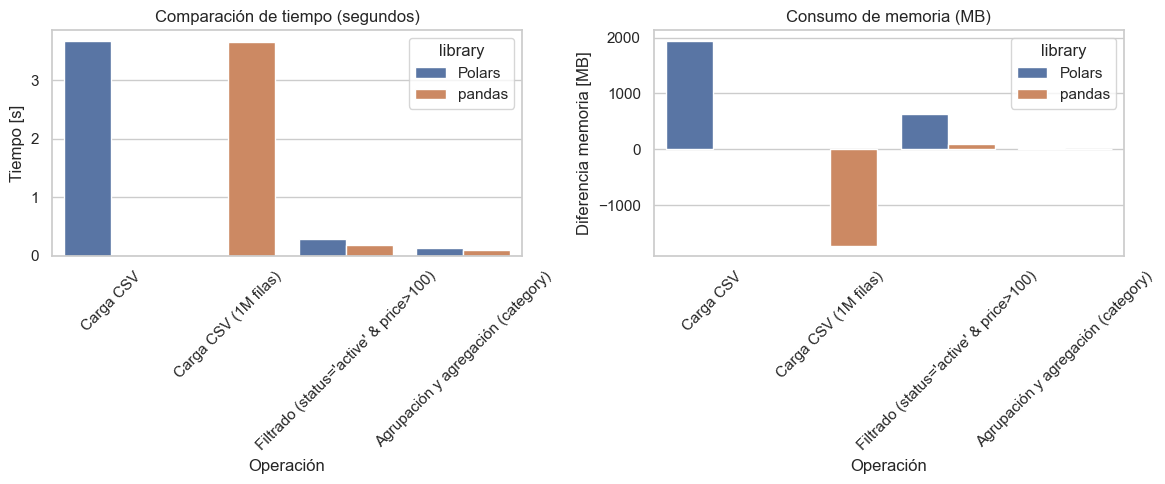

In [15]:
df_bench = benchmark_detailed(CSV_PATH, price_threshold=100.0)
plot_benchmark_results(df_bench)
